In [1]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
# import cv2
import skimage as sk
import scipy.ndimage as nd
from array import array
from functions_MuonsNSAMP1 import *
import time

from ROOT import TProfile, TGraphErrors, TH2F

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

# def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

Colormap = 'jet'

# print(time.time())
# print(time.gmtime(0))

Welcome to JupyROOT 6.28/04


In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth": 3,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Colormap = 'jet'

Filename: /home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 650)   float32   
  1                1 ImageHDU       164   (700, 650)   float32   
  2                1 ImageHDU       164   (700, 650)   float32   
  3                1 ImageHDU       164   (700, 650)   float32   
None
----------------


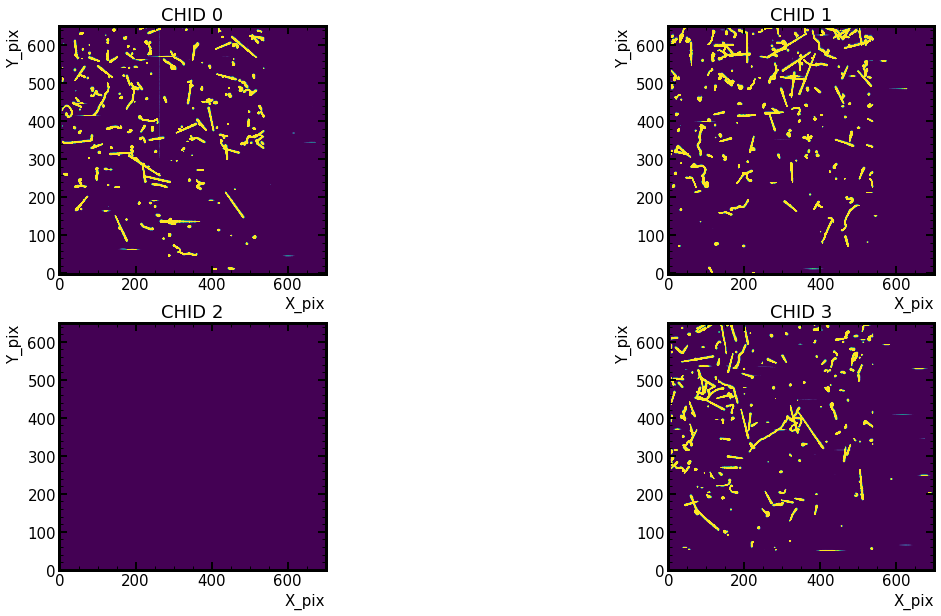

In [3]:
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits'
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits'



hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=1000,vmax=10000, cmap = 'viridis')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

# Sustrayendo el promedio por renglón

## Sustrayendo la media del renglon

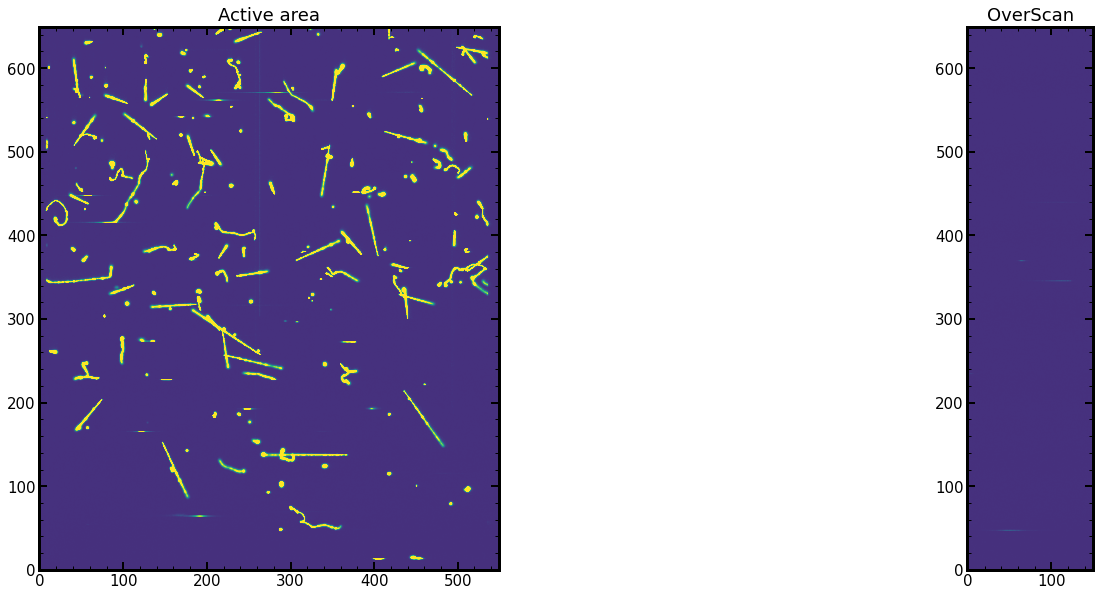

In [4]:
### Muestra el area activa y overscan de la extensión 

extension = 1
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
Overscan = hdu_list[extension - 1].data[:, 550:]
active_area = hdu_list[extension - 1].data[:, :550]


fig, axs = plt.subplots(1,2, figsize=[25,10])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
axs[0].imshow(active_area, origin='lower', vmin = 1000, vmax = 100000)
axs[0].set_title('Active area')

axs[1].imshow(Overscan, origin='lower', vmin = 1000, vmax = 100000)
axs[1].set_title('OverScan')

# plt.colorbar()
plt.show()

# fig, axs = plt.subplots(figsize=[10,10])
# active_area_mask=sk.measure.label(active_area>=np.max(active_area), connectivity=2)
# active_area_true=ma.masked_array(active_area,mask=(active_area_mask>0))
# plt.colorbar(location = 'bottom')
# plt.colorbar()

# fig.colorbar(x1, ax=axs[0])
# fig.colorbar(x2, ax=axs[1])

plt.show()


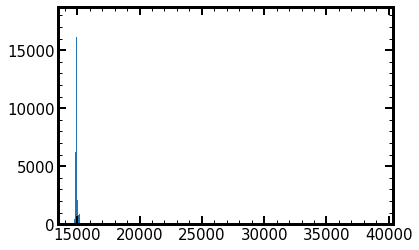

In [5]:
plt.hist(Overscan.flatten(), bins = 1000)
# plt.yscale('log')
plt.show()

In [6]:
### Dimensiones de Overscan
print('Dimensiones Oscan: ', Overscan.shape)
oscan_x = Overscan.shape[1]
oscan_y = Overscan.shape[0]


### Dimensiones de Active Area
print('Dimensiones ActA: ', active_area.shape)
acta_x = active_area.shape[1]
acta_y = active_area.shape[0]

Dimensiones Oscan:  (650, 150)
Dimensiones ActA:  (650, 550)


In [7]:
### Se sustrae la mediana de cada renglón y se crea un arreglo
mean_rows_value = []
for element in np.arange(0, oscan_y):
    row = Overscan[element: element +1, 0: oscan_x]
    num_row = element + 1
    # plt.imshow(row, origin='lower')
    # plt.show()
    # print(row.shape)
    # print(type(row))
    # print(row.sum()/row.shape[1])
    mean_value = np.median(row)
    mean_rows_value.append([mean_value])
    # print((num_row, mean_value))

print(mean_rows_value[0])

[14813.6455]


In [8]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = active_area - mean_rows_value
print(active_area[1][1])
print(true_active_area[1][1])
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del oScan
# true_Oscan = Overscan - mean_rows_value


true_Oscan = Overscan
min_oScan = np.min(true_Oscan)
# plt.imshow(true_active_area, origin='lower')

14791.263
-30.000977


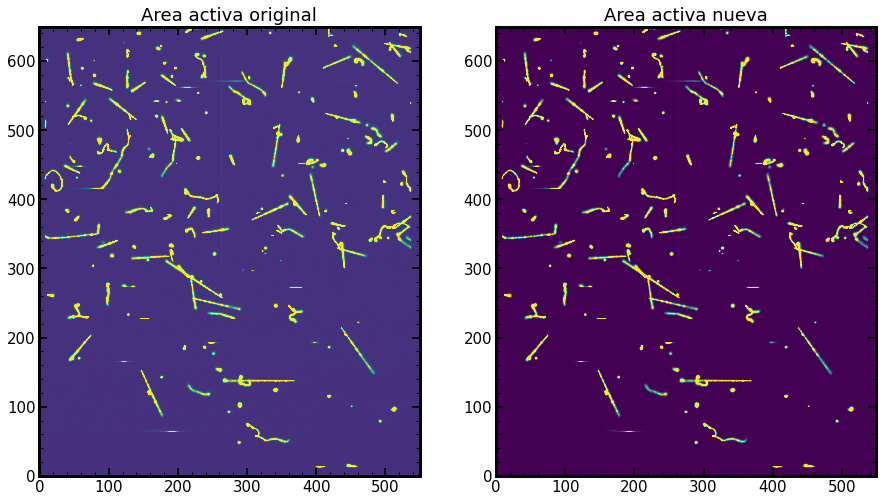

In [9]:
## Se muestra la comparación de la extensión original y despues de quitarle la mediana

Figsize = [15,15]
fig, axs = plt.subplots(1, 2, figsize=Figsize)
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Area activa original')
axs[1].set_title('Area activa nueva')
x0 = axs[0].imshow(active_area, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_active_area, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

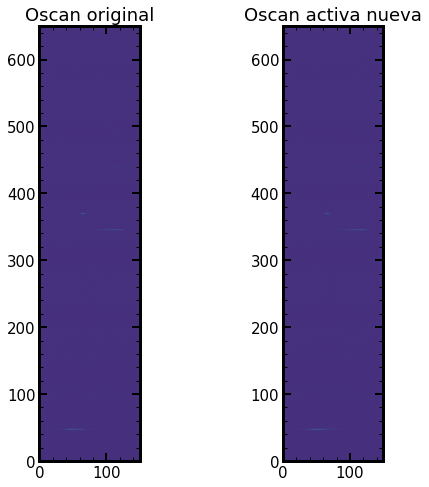

In [10]:
fig, axs = plt.subplots(1, 2, figsize=[8,8])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Oscan original')
axs[1].set_title('Oscan activa nueva')
x0 = axs[0].imshow(Overscan, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_Oscan, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


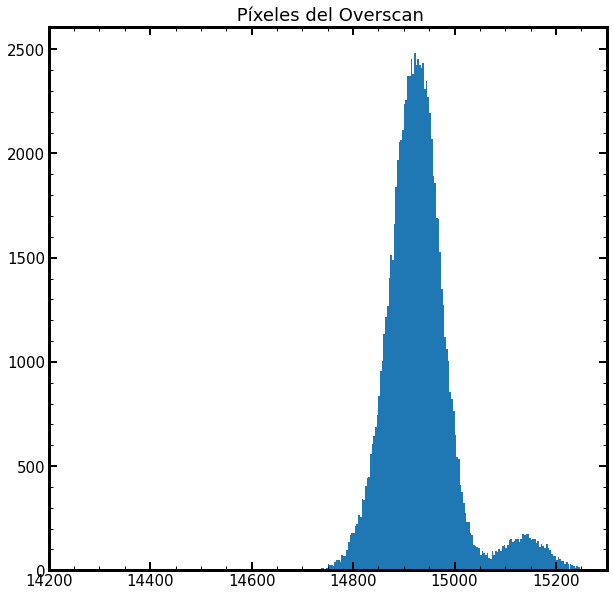

In [11]:
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

min_oScan = np.min(true_Oscan)

## Generamos el histograma de los pixeles del oScan especificando el rango
bin_heights, bin_borders, _ = axs_all.hist(true_Oscan.flatten(), bins= 300, range = (14250, 15250))# , label="Pixeles del Overscan")
# axs_all.vlines(14651.275, ymin=0, ymax=900, colors='k', linestyle = 'dashed', label = 'Offset')
# axs_all.vlines(14720.0, ymin=0, ymax=2000, colors='r')

axs_all.set_title(' Píxeles del Overscan')
plt.legend()

plt.show()

## Aplanando el Oscan

### Doble Gaussiana

Offset Value:  14918.279  ADUs
Parameters of the Doble-Gaussian Fit
Mean:  6.559216042050638  +-  0.3676467306329
Sigma:  46.027897678554794  +-  0.22550359906123807
Gain:  213.0493209201817  +-  0.8158054915880805
First Peak:  476.6918321660425  +-  2.109825825526563
Second Peak:  28.984247176259146  +-  0.4440702101231153 

chiSquare: 626.9077151558889
NDegrees of Freedom: 580
chiSquare / NDF : 1.0808753709584291
Prob: 0.08671972211340097 

 FCN=626.908 FROM MIGRAD    STATUS=CONVERGED     420 CALLS         421 TOTAL
                     EDM=1.32497e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.55922e+00   3.67647e-01  -3.63717e-04  -2.08028e-04
   2  p1           4.60279e+01   2.25504e-01   3.14548e-05  -5.50226e-04
   3  p2           2.13049e+02   8.15805e-01   3.43772e-04  -2.17703e-04
   4  p3           4

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


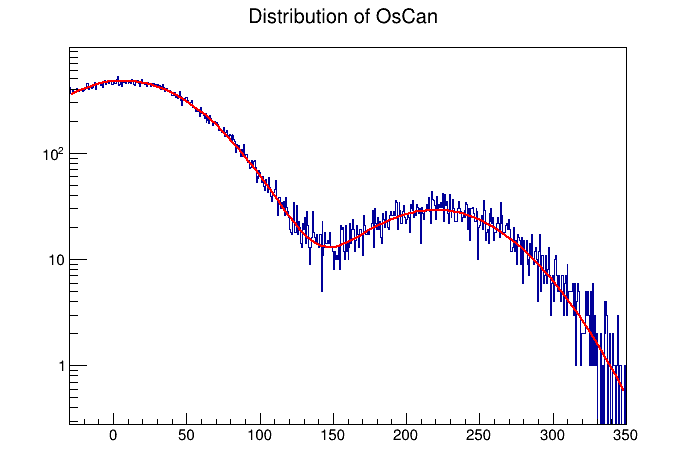

In [12]:
# min_oScan = np.min(true_Oscan)
# extension = 4
Bins = 600
Bins_fit = 600
# Range_fit = [-100, 400]

Range_fit = [-30, 350]
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset 
fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)

h3=TH1F("histogram", "Distribution of OsCan",Bins_fit,Range_fit[0],Range_fit[1])
h3.AddDirectory(False)
for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)
fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# fgaus2.SetParameters(3.999255762274112,62.819921446387646, 197.8901791750652, 106.11699858208667, 4.973093664397046)

h3.Fit(fgaus2)
c1=TCanvas()
c1.SetLogy()
h3.SetStats(0)
h3.Draw()
fgaus2.Draw("same")
c1.Draw()

gStyle.SetOptFit(1100)
gStyle.SetPadGridX (True)

# # fgaus2.Draw('Quiet')
print('Parameters of the Doble-Gaussian Fit')
print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
print('First Peak: ', fgaus2.GetParameters()[3],  ' +- ', fgaus2.GetParError(3))
print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
print("chiSquare: " + str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
print("Prob:", fgaus2.GetProb(), '\n')


In [13]:
delta_Bin = 0
dict_popt =  oScan_fit_NSAMP324_ROOT(extensión = extension, active_area = data, oScan = true_Oscan, Bins = Bins+delta_Bin, Bins_fit=Bins_fit+delta_Bin,
                                        make_figure_flag = False, range_fit=[-30, 350])

 FCN=626.908 FROM MIGRAD    STATUS=CONVERGED     420 CALLS         421 TOTAL
                     EDM=1.32497e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.55922e+00   3.67647e-01  -3.63717e-04  -2.08028e-04
   2  p1           4.60279e+01   2.25504e-01   3.14548e-05  -5.50226e-04
   3  p2           2.13049e+02   8.15805e-01   3.43772e-04  -2.17703e-04
   4  p3           4.76692e+02   2.10983e+00   2.16751e-03  -3.10758e-05
   5  p4           2.89842e+01   4.44070e-01  -2.51977e-04  -3.29730e-04


In [14]:
##### Sigma en e- ####
sig_ADUs = dict_popt['sigma']
Gain = dict_popt['Gain']
offset = dict_popt['Offset']

sig_elec = abs(( sig_ADUs) / Gain)
print('Sigma: ', sig_elec, ' e-')

Sigma:  0.21604339070293965  e-


In [15]:
dataCal, sigma = data_calibrated_NSAMP(active_area = data, extension = extension, offset = offset, gain = Gain, ratio_keV = ratio_keV, unidades = 2, sigma_ADUs = sig_ADUs)
print('Sigma: ', sigma, ' keV')

Sigma:  0.0007993605456008767  keV


### Gauss-Poisson

In [421]:
def gauss_comppoisson_fit1(x, par):
    k = 1000
    #  m = 4
    #  ydata = 0;
    xval = x[0]
    a     = par[0]
    mu    = par[1]
    sigma = par[2]
    lambda_poisson = par[3]
    pgeom = par[4]
    gain  = par[5]
    # p=1
    fitval = 0.0
    for p in np.arange(0, k):
        fitval = fitval + a * TMath.Gaus(xval*gain,p-mu,sigma,1) * TMath.PoissonI(p,lambda_poisson)

    return fitval

Offset Value:  14910.084  ADUs
Realizando el ajuste
Offset fit:  0.0  +-  0.0  ADUs
Sigma fit:  60.0  +-  0.0  ADUs
Lambda fit:  2.0  +-  0.0
Gain fit:  200.0  +-  200.0  e-/ADUs 


Chiq:  0.0
Ndegf:  0
Prob:  0.0


Warning in <TROOT::Append>: Replacing existing TH1: histo (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


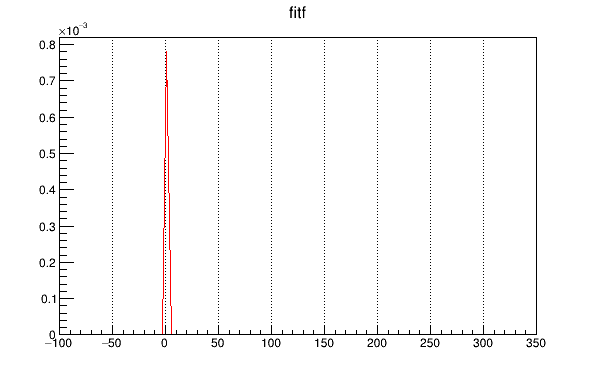

In [426]:
Bins = 1000
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset

# print(len(Overscan_plane))
# plt.hist(Overscan_plane.flatten(), bins = Bins, range=[-200, 500])

# fit_gausCONVcomppois(Overscan_plane)
data = Overscan_plane.flatten() ## get oScan data and turn 1D array
long_data = len(data)
# print('Ndata: ', long_data)
# print(data)

# print('Voy  a crear y llenar el hist')

histo = TH1F("histo","", Bins, -200, 500)
histo.GetXaxis().SetTitle("charge (e^{-})")

for pixel_value in data:
    # if not np.ma.is_masked(pixel_value):
    histo.Fill(pixel_value)
    # for ibin in np.arange(0, NBins):
    #     histo.SetBinContent(ibin,BinCont[ibin])

    # nevents = histo.Integral()
# print('N_events: ', nevents)
# print('Terminé de llenar todo, ahora haré el ajuste')

npar = 6        # nparameters
norm = 600   
offs = 0    # offset
sigm = 60    # sigma
lamb = 1  # lambda de Poisson
pgeo = 0    # probabilidad (se ignora en el cálculo)
gain = 200

lofit = -100
hifit =  350

fitf = TF1("fitf",gauss_comppoisson_fit1,lofit,hifit,npar)
fitf.SetParameter(0,norm)
fitf.SetParameter(1,offs)
fitf.SetParameter(2,sigm)
fitf.SetParameter(3,lamb)
fitf.SetParameter(4,pgeo)
fitf.SetParameter(5,gain)

# fitf.SetNpx(400)
# fitf.SetMinimum(1e-3)
fitf.SetLineWidth(1)

print('Realizando el ajuste')
# histo.Fit(fitf)
norm = fitf.GetParameter(0)
offs = fitf.GetParameter(1)
sigm = fitf.GetParameter(2)
lamb = fitf.GetParameter(3)
pgeo = fitf.GetParameter(4)
gain = fitf.GetParameter(5)

norme = fitf.GetParError(0)
offse = fitf.GetParError(1)
sigme = fitf.GetParError(2)
lambe = fitf.GetParError(3)
pgeoe = fitf.GetParError(4)
gaine = fitf.GetParError(5)

chisq = fitf.GetChisquare()
ndegf = fitf.GetNDF()
proba = fitf.GetProb()

canv = TCanvas("canv","",600,400)
#histo.Draw()
fitf.Draw("")

canv.Draw()

dict_info = {'par' : {'Offset':offs, 'Sigma':sigm, 'Gain':gain}, 'err' :  {'Offset':offse, 'Sigma':sigme, 'Gain':gaine},
                'fit_quality': {'Chiq' : chisq, 'Ndegf' : ndegf, 'Prob': proba}}

# print(dict_info)
print('Offset fit: ', offs, ' +- ', offse, ' ADUs')
print('Sigma fit: ', sigm, ' +- ', sigme, ' ADUs')
print('Lambda fit: ', lamb, ' +- ', lambe)
print('Gain fit: ', gain, ' +- ', gain, ' e-/ADUs \n\n' )

print('Chiq: ', chisq)
print('Ndegf: ', ndegf)
print('Prob: ', proba)



## Curva de electrones del area activa

Offset Value:  14920.0  ADUs
Parameters of the Doble-Gaussian Fit
Mean:  1707.5299808000136  +-  3.596266343500761
Sigma:  -57.59552648969373  +-  2.611628740596502
Gain:  214.91229823682923  +-  5.213903295003742
chiSquare: 382.1418337582057
NDegrees of Freedom: 496
chiSquare / NDF : 0.7704472454802533
Prob: 0.9999546520230078 

 FCN=382.142 FROM MIGRAD    STATUS=CONVERGED    1660 CALLS        1661 TOTAL
                     EDM=1.51682e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.70753e+03   3.59627e+00   2.66103e-02  -3.77401e-06
   2  p1          -5.75955e+01   2.61163e+00   1.66162e-02   4.31576e-06
   3  p2           2.14912e+02   5.21390e+00   3.52613e-02  -1.13993e-07
   4  p3           3.45298e+00   1.61970e-01   1.31813e-03  -1.64261e-05
   5  p4           2.67182e+00   1.41456e-01   1.15843e-03  -1.07175e-04


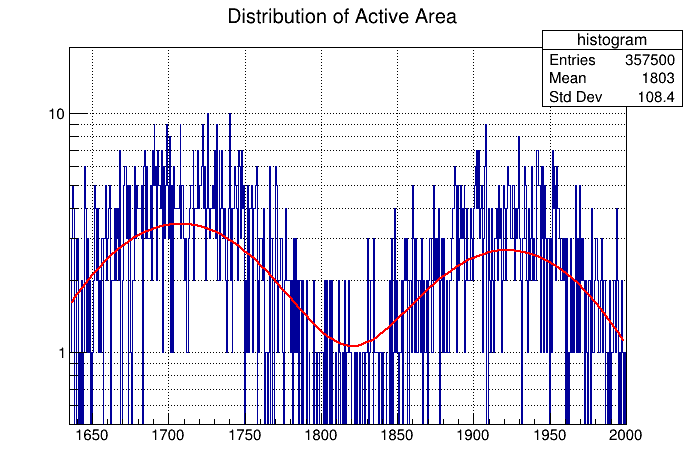

In [111]:
# min_oScan = np.min(true_Oscan)
# extension = 4
Bins = 600
Bins_fit = 600
# Range_fit = [-100, 400]

# Range_fit = [-100, 1700]
# Range_fit = [-50, 300] # Primeros dos picos
# Range_fit = [140, 530] # Segundo y tercer pico
# Range_fit = [390, 740] # tercer y cuarto pico
# Range_fit = [590, 940] # cuarto y quinto pico
# Range_fit = [1030, 1350] # quinto y sexto pico
# Range_fit = [1200, 1580] # sexto y séptimo pico
# Range_fit = [1400, 1800] # séptimo y octavo pico
Range_fit = [1635, 2000] # octavo y noveno pico




ratio_keV = 0.0037  ## KeV/e-

data = hdu_list[extension-1].data[:, :550]
# print(data[0:1])
# data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(data.flatten(), bins = Bins,  range=(14000, 16000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = data - offset 
fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",Range_fit[0],Range_fit[1],5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)

h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
h3.AddDirectory(False)
for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)
# fgaus2.SetParameters(0,1,218, 1000, 500) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# fgaus2.SetParameters(218,1, 433, 500, 100)
# fgaus2.SetParameters(433,40, 570, 100, 50)
# fgaus2.SetParameters(647,40, 861, 100, 50)
# fgaus2.SetParameters(858,40, 1068, 100, 50)
# fgaus2.SetParameters(1069,40, 1279, 100, 50)
fgaus2.SetParameters(1708,50, 1930, 10, 11)



# fgaus2.SetParameters(3.999255762274112,62.819921446387646, 197.8901791750652, 106.11699858208667, 4.973093664397046)

h3.Fit(fgaus2)
c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# h3.SetStats(0)
h3.Draw()
fgaus2.Draw("same")
c1.Draw()

# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)

# fgaus2.Draw('Quiet')
print('Parameters of the Doble-Gaussian Fit')
print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
# print('First Peak: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
print("chiSquare: " + str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
print("Prob:", fgaus2.GetProb(), '\n')


## Ajuste de curva

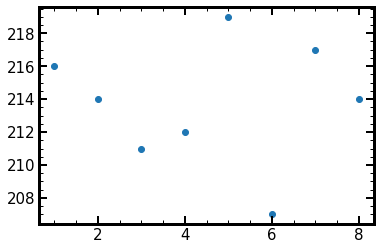

In [115]:
list_gains = [216, 214, 211, 212, 219, 207, 217, 214]
list_points = [1,2,3,4,5,6,7,8]

list_err_gains = [0.289, 0.382, 0.771, 1.09, 2.85, 3.212, 2.473, 3.317, 5.216]
list_err_poinst = [0,0,0,0,0,0,0,0]

plt.scatter(list_points, list_gains)

Parameters of the Fit
Origen:  216.53946426901  +-  0.40159085233487296
Pend:  -1.0166122100398591  +-  0.19955255966336652
chiSquare: 35.4808703849618
NDegrees of Freedom: 6
chiSquare / NDF : 5.913478397493633
Prob: 3.4768909385202316e-06 

 FCN=35.4809 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=5.95235e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.16539e+02   4.01591e-01   6.31295e-04   1.06926e-09
   2  p1          -1.01661e+00   1.99553e-01   3.13694e-04   3.11449e-09


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


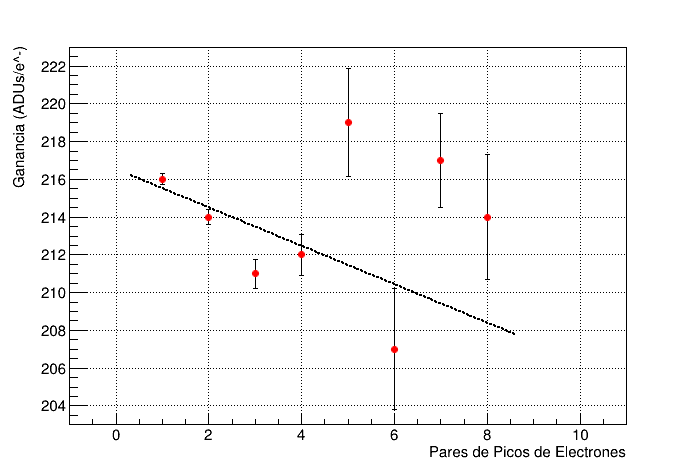

In [181]:
GRprofXY = TGraphErrors()
lox = 0
hix = 10

for index in np.arange(0, len(list_gains)):
    GRprofXY.SetPoint(int(index), list_points[index], list_gains[index])
    GRprofXY.SetPointError(int(index), list_err_poinst[index], list_err_gains[index])

fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(215, 1)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit("fitline")  #### Funcionó aunque los paŕametros iniciales fueron malos


NBX=10
NBY=220
canv = TCanvas("c2")
canv.SetGrid()
frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,NBY-17,NBY+3)
frame.GetXaxis().SetTitle("Pares de Picos de Electrones")
frame.GetYaxis().SetTitle("Ganancia (ADUs/e^-)")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.8)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')

Parameters of the Fit
Origen:  0.998342630085829  +-  0.0007290753242036732
Pend:  0.004642978194825908  +-  2.7706277407006454e-06
chiSquare: 210.69554981268215
NDegrees of Freedom: 6
chiSquare / NDF : 35.115924968780355
Prob: 1.0011701556693258e-42 

Parameters of the Non-linear Fit
Origen:  1.003086758999477  +-  0.0007925600226322601
Pend:  0.004576728062600133  +-  5.434066427999075e-06
Non-linear term:  -1.6137303445862074e-05  +-  1.158470378035804e-06
chiSquare: 16.80051387232579
NDegrees of Freedom: 5
chiSquare / NDF : 3.360102774465158
Prob: 0.004894086560871949 

 FCN=210.696 FROM MIGRAD    STATUS=CONVERGED      99 CALLS         100 TOTAL
                     EDM=2.95624e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.98343e-01   7.29075e-04   4.25916e-06  -1.27427e+00
   2  p1           4.64298e-03   2.77063e-06 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


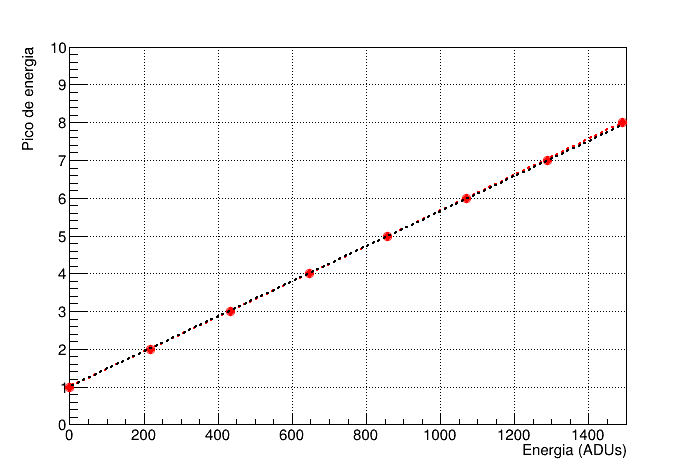

In [207]:
list_means = [-0.75, 217.21, 433.6, 647.21, 857.01, 1068.5, 1287.198, 1491.65, 1707.52]
list_picos = [1, 2, 3, 4, 5, 6, 7, 8, 9]

list_err_means = [0.18, 0.211, 0.529, 0.711, 1.869, 2.241, 1.683, 1.976, 3.597]
list_err_picos = [0,0,0,0,0,0,0,0,0]


GRprofXY = TGraphErrors()
lox = 0
hix = 1800

for index in np.arange(0, len(list_gains)):
    GRprofXY.SetPoint(int(index), list_means[index], list_picos[index])
    GRprofXY.SetPointError(int(index), list_err_means[index], list_err_picos[index])


fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(1, 1)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit("fitline")  

fitnonline = TF1("fitnonline", "[0]+[1]*x/(1+[2]*x)",lox,hix) 
fitnonline.SetParameters(1, 0.01, -0.00001)
fitnonline.SetLineStyle(2)
fitnonline.SetLineColor(2)
GRprofXY.Fit("fitnonline") 


NBX=1500
NBY=10
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (ADUs)")
frame.GetYaxis().SetTitle("Pico de energia")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(1.)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
fitline.Draw("L same")
# fitnonline.Draw("L same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')


print('Parameters of the Non-linear Fit')
print('Origen: ', fitnonline.GetParameters()[0],  ' +- ', fitnonline.GetParError(0))
print('Pend: ', fitnonline.GetParameters()[1],  ' +- ', fitnonline.GetParError(1))
print('Non-linear term: ', fitnonline.GetParameters()[2],  ' +- ', fitnonline.GetParError(2))

print("chiSquare: " + str(fitnonline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitnonline.GetNDF()))
print("chiSquare / NDF :", fitnonline.GetChisquare() / fitnonline.GetNDF())
print("Prob:", fitnonline.GetProb(), '\n')
